In [1]:
import tweepy 
import configparser
import requests     # For saving access tokens and for file management when creating and adding to the dataset
import os           # For dealing with json responses we receive from the API
import json         # For displaying the data after
import pandas as pd # For saving the response data in CSV format
import csv          # For parsing the dates received from twitter in readable formats
import datetime
import dateutil.parser
import unicodedata  #To add wait time between requests
import time
import sqlite3
import re
import twitter
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired, MaximalMarginalRelevance,PartOfSpeech
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
from nltk.corpus import stopwords
from sklearn.model_selection import RandomizedSearchCV
from flair.embeddings import TransformerDocumentEmbeddings
import numpy as np
from twitter import *
from functools import partial
from collections import Counter
import nltk
import string
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Read Configs

The following code reads configuration values from a `config.ini` file.

#### Usage

1. Ensure you have a `config.ini` file with the required values.
2. Replace the placeholders with your actual configuration values.
3. Run the code to read the configuration.

#### Example `config.ini` File

```ini
[twitter]
api_key = YOUR_API_KEY
api_key_secret = YOUR_API_KEY_SECRET
access_token = YOUR_ACCESS_TOKEN
access_token_secret = YOUR_ACCESS_TOKEN_SECRET
bearer_token = YOUR_BEARER_TOKEN

In [2]:
"""Read configuration values from the 'config.ini' file.
    
    Returns:
        api_key (str): The API key for Twitter.
        api_key_secret (str): The API key secret for Twitter.
        access_token (str): The access token for Twitter.
        access_token_secret (str): The access token secret for Twitter.
        bearer_token (str): The bearer token for Twitter.
"""

config = configparser.ConfigParser()
config.read('config.ini')

api_key             = config['twitter']['api_key']
api_key_secret      = config['twitter']['api_key_secret']

access_token        = config['twitter']['access_token']
access_token_secret = config['twitter']['access_token_secret']

bearer_token        = config['twitter']['bearer_token']

print(api_key)
print(api_key_secret)
print(access_token)
print(access_token_secret)

thbWUU1U2LidgvkLhowEv1po6
9mbQH44TbecTOLx5YH2ZtuFoHIGaBXQCSXmbl8q1Xd0VIplCA3
1064695174075314176-9hrLuZmbERuLjZWrnSS3WKf37bMhb1
GnMtbeiVNcvV4QtWkjILL0XqOY7XrPksTFH0ZlUR3Mo7w


### Authenticate with the Twitter API

The following code authenticates your account with the Twitter API using the provided credentials.

### Usage

1. Replace the placeholders (`api_key`, `api_key_secret`, `access_token`, `access_token_secret`, `bearer_token`) with your actual Twitter API credentials.
2. Run the code to authenticate your account and print the screen name/username of the authenticated account.


In [3]:
def authenticate_twitter_api(api_key, api_key_secret, access_token, access_token_secret, bearer_token):
    """
    Authenticate with the Twitter API using the provided credentials.

    Args:
        api_key (str): The API key for Twitter.
        api_key_secret (str): The API key secret for Twitter.
        access_token (str): The access token for Twitter.
        access_token_secret (str): The access token secret for Twitter.
        bearer_token (str): The bearer token for Twitter.

    Returns:
        str: The screen name/username of the authenticated account.
    """
    t = Twitter(auth=OAuth(access_token, access_token_secret, api_key, api_key_secret))
    
t = authenticate_twitter_api(api_key, api_key_secret, access_token, access_token_secret, bearer_token)

## Set up SQLite database

The following code sets up an SQLite database and creates two tables: `tweets` and `users`.


In [2]:
# Set up SQLite database
conn = sqlite3.connect('twitter_data.db')
c = conn.cursor()

In [3]:
# Create table for tweet data
c.execute('''CREATE TABLE IF NOT EXISTS tweets
             (tweet_id INTEGER PRIMARY KEY,
              author_id INTEGER,
              created_at TIMESTAMP,
              text TEXT,
              tweet_metrics JSON,
              entities JSON,
              context JSON,
              place_id JSON,
              FOREIGN KEY (author_id) REFERENCES users(author_id),
              FOREIGN KEY (place_id) REFERENCES users(place_id))''')

In [4]:
# Create table for user data
c.execute('''CREATE TABLE IF NOT EXISTS users
             (author_id INTEGER PRIMARY KEY,
              username TEXT,
              verified TEXT,
              bio TEXT,
              author_created TIMESTAMP,
              author_location TEXT,
              followers_count INTEGER,
              following_count INTEGER,
              tweet_count INTEGER,
              entities JSON,
              FOREIGN KEY (author_id) REFERENCES tweets(author_id))''')

In [5]:
c.execute("PRAGMA table_info(tweets)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT tweet_id) FROM tweets")
row_count = c.fetchone()[0]
print(f"Number of rows in 'tweets' table: {row_count}\n")


c.execute("PRAGMA table_info(users)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT author_id) FROM users")
row_count = c.fetchone()[0]
print(f"Number of rows in 'users' table: {row_count}\n")

tweet_id - INTEGER
author_id - INTEGER
created_at - TIMESTAMP
text - TEXT
tweet_metrics - JSON
entities - JSON
context - JSON
place_id - JSON


Number of rows in 'tweets' table: 36370

author_id - INTEGER
username - TEXT
verified - TEXT
bio - TEXT
author_created - TIMESTAMP
author_location - TEXT
followers_count - INTEGER
following_count - INTEGER
tweet_count - INTEGER
entities - JSON
Number of rows in 'users' table: 14026



## DATA EXTRACTION

### Function: get_tweets

**Description:**
Fetches recent tweets from the Twitter API based on a given query.

**Parameters:**
- query (str): The query string to search for tweets.
- max_results (int): The maximum number of tweets to fetch.

**Returns:**
- List of tweets (objects): A list of fetched tweets matching the query.

**Raises:**
- Exception: If there is an error while fetching tweets.


In [8]:
def get_tweets(query, max_results):
  """
    Fetches recent tweets from the Twitter API based on a given query.

    Parameters:
        query (str): The query string to search for tweets.
        max_results (int): The maximum number of tweets to fetch.

    Returns:
        List of tweets (objects): A list of fetched tweets matching the query.

    Raises:
        Exception: If there is an error while fetching tweets.
  """
  expansions    = ['author_id','in_reply_to_user_id','geo.place_id','entities.mentions.username','referenced_tweets.id','referenced_tweets.id.author_id']
  tweet_fields  = ['id','text','author_id','attachments','context_annotations','created_at','entities','lang','geo','public_metrics']
  user_fields   = ['id','name','username','created_at','description','entities','location','public_metrics','verified']
  place_fields  = ['full_name','id','country','country_code','geo','name','place_type']
  try:
    # call twitter api to fetch tweets
    fetched_tweets = tweepy.Paginator(client.search_recent_tweets, query=query,
      expansions        =expansions,
      tweet_fields      =tweet_fields,
      place_fields      =place_fields,
      user_fields       =user_fields,   
      max_results       =max_results
    ).flatten()
    
    return fetched_tweets
    

  except Exception as e:
    print("Error getting tweets", e)

### Function: automate_domain_filter

**Description:**
Automates the process of creating chunks of query strings for domain filtering based on the provided DataFrame.

**Parameters:**
- df (DataFrame): The DataFrame containing the domain information.
- start_id (int): The starting domain ID.
- end_id (int): The ending domain ID.
- chunk_size (int): The maximum size of each chunk in characters.
- domain_chunk_count (dict): A dictionary specifying the number of chunks for each domain ID.

**Returns:**
- List of chunks (list): A list of query string chunks.


In [12]:
domain_df = pd.read_csv('twitter-context-annotations/files/evergreen-context-entities-20220601.csv')
import itertools
def automate_domain_filter(df, start_id, end_id, chunk_size, domain_chunk_count):
    """
    Automates the process of creating chunks of query strings for domain filtering based on the provided DataFrame.

    Parameters:
        df (DataFrame): The DataFrame containing the domain information.
        start_id (int): The starting domain ID.
        end_id (int): The ending domain ID.
        chunk_size (int): The maximum size of each chunk in characters.
        domain_chunk_count (dict): A dictionary specifying the number of chunks for each domain ID.

    Returns:
        List of chunks (list): A list of query string chunks.
    """
    chunks_list = []
    for i in range(start_id, end_id+1):
        context_list = []
        mask = df['domains'].str.contains('^{}$'.format(i))
        filtered_df = df[mask]
        for index, row in filtered_df.iterrows():
            domain_id = row['domains']
            entity_id = row['entity_id']
            entity_name = row['entity_name']   
            # construct the query string
            context = f'context:{domain_id}.{entity_id}'
            context_list.append(context)
            context_query = ' OR '.join(context_list)
        code = context_query
        chunks = []
        start = 0
        counter = 0
        while start < len(code) and counter < domain_chunk_count[i]:
            end = start + chunk_size
            if end >= len(code):
                end = len(code)
            end = code.rfind(" OR ", start, end)
            if end == -1:
                end = start + chunk_size
            chunk = code[start:end]
            if chunk.startswith(" OR "):
                chunk = chunk[4:]
            chunks.append(chunk)
            start = end
            counter += 1
        chunks_list.append(chunks)
    return list(itertools.chain.from_iterable(chunks_list))

chunk_size = 350
domain_chunk_count = {45: 1, 46: 6, 47: 276, 48: 69}
chunks_list = automate_domain_filter(domain_df, 45, 48, chunk_size, domain_chunk_count)

### Function: filter_rule

**Description:**
Creates a query string for filtering tweets based on the provided chunk.

**Parameters:**
- chunk (str): The chunk representing a portion of the query string.
- hash_include (bool): Flag indicating whether to include hashtag-related filter rules. Default is True.

**Returns:**
- query (str): The constructed query string.

In [11]:
def filter_rule(chunk, hash_include=True):
    """
    Creates a query string for filtering tweets based on the provided chunk.

    Parameters:
        chunk (str): The chunk representing a portion of the query string.
        hash_include (bool): Flag indicating whether to include hashtag-related filter rules. Default is True.

    Returns:
        query (str): The constructed query string.
    """
    text_list       = '(#ad OR #sponsored OR #promoted OR "Learn More" OR "Shop Now")'
    lang            = '(lang:en)'
    rt              = '(-is:retweet) (-"RT")' 
    domain            = chunk
    mention         = 'has:mentions'
    if hash_include == True:
        query           = text_list + ' ' + lang + ' ' + rt + ' ' + mention + ' ' + '(' + domain + ')'
    else: 
        query           = lang + ' ' + rt + ' ' + mention + ' ' + '(' + domain + ')'

    return query

The following code retrieves tweets using the generated chunks and stores the tweet data in a list called `tweet_data`. It iterates over each chunk, applies the filter rule, and retrieves tweets using the `get_tweets` function. The retrieved tweet information is then appended to the `tweet_data` list.


In [ ]:
import time
import tweepy
import pandas as pd

processed_tweets = 0
total_tweets = 0

tweet_data = []  # List to store tweet data

for chunk in chunks_list:
    print(f'Chunk: {chunk}')
    
    query = filter_rule(chunk=chunk,hash_include=True)
    paginator = get_tweets(query=query, max_results=100)

    if paginator is None:
        print('Error: Paginator is None. Skipping chunk.')
        continue
    
    for tweet in paginator:
        tweet_info = {
                'tweet_id': tweet.id,
                'author_id': tweet.author_id,
                'created_at': tweet.created_at,
                'text': tweet.text,
                'tweet_metrics': json.dumps(tweet.public_metrics),
                'entities': json.dumps(tweet.entities),
                'context': json.dumps(tweet.context_annotations),
                'place_id': json.dumps(tweet.geo) if tweet.geo else None
            }
            
        tweet_data.append(tweet_info)
        processed_tweets += 1
    
    
    print(f'Finished processing chunk: {chunk}')
    print(f'Progress: {processed_tweets} tweets processed.')
    time.sleep(3)  # Pause for 5 minutes between chunks to avoid hitting rate limits


The code snippet converts the `tweet_data` list into a DataFrame called `df`. It then sorts the DataFrame in ascending order based on the 'tweet_id' column. Next, it drops duplicate rows based on the 'tweet_id' column, keeping only the last occurrence of each tweet. The resulting DataFrame is stored in the `dedup_df` variable.


In [7]:
# Convert tweet_data list to a DataFrame
df = pd.DataFrame(tweet_data)

# Sort the DataFrame by 'tweet_id' in descending order
df.sort_values('tweet_id', ascending=True, inplace=True)

# Drop duplicate rows based on 'tweet_id' column, keeping the last occurrence
dedup_df = df.drop_duplicates(subset='tweet_id', keep='last', inplace=False).reset_index(drop=True, inplace=False)

print(dedup_df.shape)

NameError: name 'tweet_data' is not defined

### Function process_tweets_to_database

The code snippet defines a function `process_tweets_to_database` that processes tweets from a DataFrame and inserts or updates them in a SQLite database.

In [ ]:
def process_tweets_to_database(df, conn, c):
    """
    Processes tweets from a DataFrame and inserts or updates them in a SQLite database.

    Args:
        df (pandas.DataFrame): DataFrame containing tweet data.
        conn (sqlite3.Connection): SQLite database connection.
        c (sqlite3.Cursor): SQLite database cursor.

    Returns:
        int: Number of tweets processed.

    """
    processed_tweets = 0

    for index, tweet in df.iterrows():
        try:
            created_at = tweet['created_at'].strftime('%Y-%m-%d %H:%M:%S')
            # Check if tweet with the same tweet_id already exists in the database
            c.execute('SELECT tweet_id FROM tweets WHERE tweet_id=?', (tweet['tweet_id'],))
            existing_tweet_id = c.fetchone()

            if existing_tweet_id is None:
                # Tweet doesn't exist in the database, insert it
                c.execute('''INSERT INTO tweets 
                             (tweet_id, author_id, created_at, text, tweet_metrics, entities, context, place_id) 
                             VALUES (?, ?, ?, ?, ?, ?, ?, ?)''',
                          (tweet['tweet_id'], tweet['author_id'], created_at, tweet['text'],
                           tweet['tweet_metrics'], tweet['entities'], tweet['context'], tweet['place_id']))
                print("New Tweet Appended")
            else:
                # Tweet already exists, update tweet_metrics
                c.execute('''UPDATE tweets 
                             SET tweet_metrics = ? 
                             WHERE tweet_id = ?''',
                          (tweet['tweet_metrics'], tweet['tweet_id']))
                print("Tweet Already Exists, Updating Tweet Metrics")
            processed_tweets += 1

            print(f'Progress: {processed_tweets} tweets processed.')

        except Exception as e:
            print(f"Error inserting row: {tweet}")
            print(f"Error message: {e}")

    # Commit the changes and close the connection
    conn.commit()

    return processed_tweets

process_tweets_to_database(df=dedup_df, conn=conn, c=c)


In [ ]:
# Get unique author IDs from the tweets table
c.execute("SELECT DISTINCT author_id FROM tweets")
author_ids = [str(row[0]) for row in c.fetchall()]

user_data = []
batch_size = 100
n = 0

# Iterate over batches of author IDs
for i in range(0, len(author_ids), batch_size):  
    # Get a batch of user IDs
    user_ids_batch = author_ids[i:i+batch_size]    
    try:
        users = t.users.lookup(user_id=",".join(user_ids_batch))
        
    # Insert or update the user data in the database
        for user in users:
            # Check if author already exists in the database
            c.execute("SELECT author_id FROM users WHERE author_id=?",  (user['id_str'],))
            existing_author_id = c.fetchone()

            if existing_author_id is None:
                # Author doesn't exist in the database, insert a new row
                author_created = user['created_at']
                c.execute('''INSERT INTO users (author_id, username, verified, bio, author_created, author_location, 
                            followers_count, following_count, tweet_count, entities)
                            VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',
                            (user['id_str'], user['screen_name'], user['verified'], user['description'], author_created,
                            user['location'], user['followers_count'], user['friends_count'], user['statuses_count'],
                           json.dumps(user['entities'])))
                print(f"Stored author: {user['name']} (@{user['screen_name']}), id={user['id_str']}")
            else:
                # Author already exists in the database, update the existing row
                author_created = user['created_at']
                c.execute('''UPDATE users SET username=?, verified=?, bio=?, author_created=?, author_location=?, 
                            followers_count=?, following_count=?, tweet_count=?, entities=?
                            WHERE author_id=?''',
                            (user['screen_name'], user['verified'], user['description'], author_created,
                            user['location'], user['followers_count'], user['friends_count'], user['statuses_count'],
                           json.dumps(user['entities']), user['id_str']))
                print(f"Updated author: {user['name']} (@{user['screen_name']}), id={user['id_str']}")
        
    except Exception as e:
        print(f"Error retrieving user data: {str(e)}")
    time.sleep(10)
    conn.commit()

In [6]:
c.execute("PRAGMA table_info(tweets)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT tweet_id) FROM tweets")
row_count = c.fetchone()[0]
print(f"Number of rows in 'tweets' table: {row_count}\n")

print("\n")

c.execute("PRAGMA table_info(users)")
columns = c.fetchall()

for column in columns:
    print(column[1], "-", column[2])

c.execute("SELECT COUNT(DISTINCT author_id) FROM users")
row_count = c.fetchone()[0]
print(f"Number of rows in 'users' table: {row_count}\n")

tweet_id - INTEGER
author_id - INTEGER
created_at - TIMESTAMP
text - TEXT
tweet_metrics - JSON
entities - JSON
context - JSON
place_id - JSON
Number of rows in 'tweets' table: 36370



author_id - INTEGER
username - TEXT
verified - TEXT
bio - TEXT
author_created - TIMESTAMP
author_location - TEXT
followers_count - INTEGER
following_count - INTEGER
tweet_count - INTEGER
entities - JSON
Number of rows in 'users' table: 14026



### Retrieve Data from SQLite Database

The following code retrieves data from the SQLite database and creates Pandas DataFrames: `tweets_df` and `users_df`.


In [5]:
# Retrieve the data from the SQLite database
query = "SELECT * FROM tweets"
tweets_df = pd.read_sql_query(query, conn, parse_dates=['created_at'])
print(tweets_df.dtypes)


# Retrieve the data from the SQLite database
query = "SELECT * FROM users"
users_df = pd.read_sql_query(query, conn, parse_dates=['author_created'])
print(users_df.dtypes)

tweet_id                  int64
author_id                 int64
created_at       datetime64[ns]
text                     object
tweet_metrics            object
entities                 object
context                  object
place_id                 object
dtype: object
author_id                        int64
username                        object
verified                        object
bio                             object
author_created     datetime64[ns, UTC]
author_location                 object
followers_count                  int64
following_count                  int64
tweet_count                      int64
entities                        object
dtype: object


In [8]:
users_df.head()

,author_id,username,verified,bio,author_created,author_location,followers_count,following_count,tweet_count,entities
0,10305,johnjwall,0,"@TrustInsights, photographer, husband, father, co-host of @MktgOverCoffee, and author of B2B Marketing Confessions.",2006-10-24 13:00:00+00:00,Boston,4684,2011,14105,"{""url"": {""urls"": [{""url"": ""http://t.co/qZiW3k2FMr"", ""expanded_url"": ""http://www.jw5150.com"", ""display_url"": ""jw5150.com"", ""indices"": [0, 22]}]}, ""description"": {""urls"": []}}"
1,11511,Acer,0,We create technology that empowers you to #MakeYourGreenMark,2006-11-05 01:46:51+00:00,,139345,414,34568,"{""url"": {""urls"": [{""url"": ""https://t.co/OKLUIWt4mH"", ""expanded_url"": ""https://linktr.ee/acerglobal"", ""display_url"": ""linktr.ee/acerglobal"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
2,12522,cc_chapman,0,Professor. Creator. Digital Dad. Trying to leave it better than I found it.,2006-11-15 15:03:14+00:00,"Boston, MA",43466,24150,1911,"{""url"": {""urls"": [{""url"": ""https://t.co/k92JQnXlsC"", ""expanded_url"": ""https://www.cc-chapman.com"", ""display_url"": ""cc-chapman.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
3,623623,Bwana,0,"Live, Laugh & Learn | 2 Timothy 1:7 🙏 Follower of Christ | Sponsored by @Corsair | #3dprinting | 📧business@bwana.tv",2007-01-10 22:57:00+00:00,"Jacksonville, FL",6351,138,19335,"{""url"": {""urls"": [{""url"": ""https://t.co/h2IlwZu9nw"", ""expanded_url"": ""http://solo.to/bwana"", ""display_url"": ""solo.to/bwana"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"
4,689273,CiscoUmbrella,0,Cisco Umbrella (formerly OpenDNS) provides the first line of defense against threats on the internet wherever users go. Support: umbrella-support@cisco.com,2007-01-23 22:10:38+00:00,San Francisco,76112,5543,11856,"{""url"": {""urls"": [{""url"": ""https://t.co/c2stIykSYB"", ""expanded_url"": ""https://umbrella.cisco.com"", ""display_url"": ""umbrella.cisco.com"", ""indices"": [0, 23]}]}, ""description"": {""urls"": []}}"


## Exploratory Data Analysis

### Data Aggregation and DataFrame Creation

The following code aggregates data based on domain ID and creates a new DataFrame from the selected columns of the original tweets DataFrame.


In [11]:
def aggregate_data(df):
    """
    Aggregate data based on domain ID from the provided tweets DataFrame.

    Args:
        tweets_df (pd.DataFrame): DataFrame containing tweet data.

    Returns:
        pd.DataFrame: DataFrame with aggregated data based on domain ID.
    """
    subset_df = df[['tweet_id', 'author_id', 'tweet_metrics', 'context', 'entities']]

    subset_context_items = []
    for index, row in subset_df.iterrows():
        context_list = json.loads(row['context'])
        tweet_id     = row['tweet_id']
        author_id    = row['author_id']
        for item in context_list:
            domain_id   = item['domain']['id']
            domain_name = item['domain']['name']
            entity_id   = item['entity']['id']
            entity_name = item['entity']['name']
            data = {'tweet_id': tweet_id, 'author_id': author_id, 'domain_id':domain_id, 'domain_name': domain_name, 'entity_id':entity_id, 'entity_name': entity_name}
            subset_context_items.append(data)

    subset_context_item_df = pd.DataFrame(subset_context_items)
    return subset_context_item_df

subset_context_item_df = aggregate_data(df=tweets_df)

In [12]:
def calculate_top_counts(data_frame, group_by_cols, aggregate_col, top_n):
    """
    Calculate the top counts based on the given DataFrame, group by columns, aggregate column, and number of top counts to retrieve.
    
    Parameters:
        data_frame (pandas.DataFrame): DataFrame containing the data to perform calculations on.
        group_by_cols (list): List of columns to group by.
        aggregate_col (str): Column to perform aggregation on.
        top_n (int): Number of top counts to retrieve.
        
    Returns:
        pandas.DataFrame: Top counts, sorted in descending order.
    """
    subset_agg = data_frame.groupby(by=group_by_cols).agg({aggregate_col: pd.Series.nunique}).reset_index().sort_values(by=aggregate_col, ascending=False)
    top_counts = subset_agg.head(top_n)
    
    return top_counts

top_20_domain_counts = calculate_top_counts(subset_context_item_df, ["domain_name"], "tweet_id", 20)
top_50_entity_counts = calculate_top_counts(subset_context_item_df, ["entity_name"], "tweet_id", 50)
top_25_user_counts = calculate_top_counts(subset_context_item_df, ["author_id"], "tweet_id", 25)

<ipython-input-13-f8bdaa6e06df>:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)
<ipython-input-13-f8bdaa6e06df>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=60)


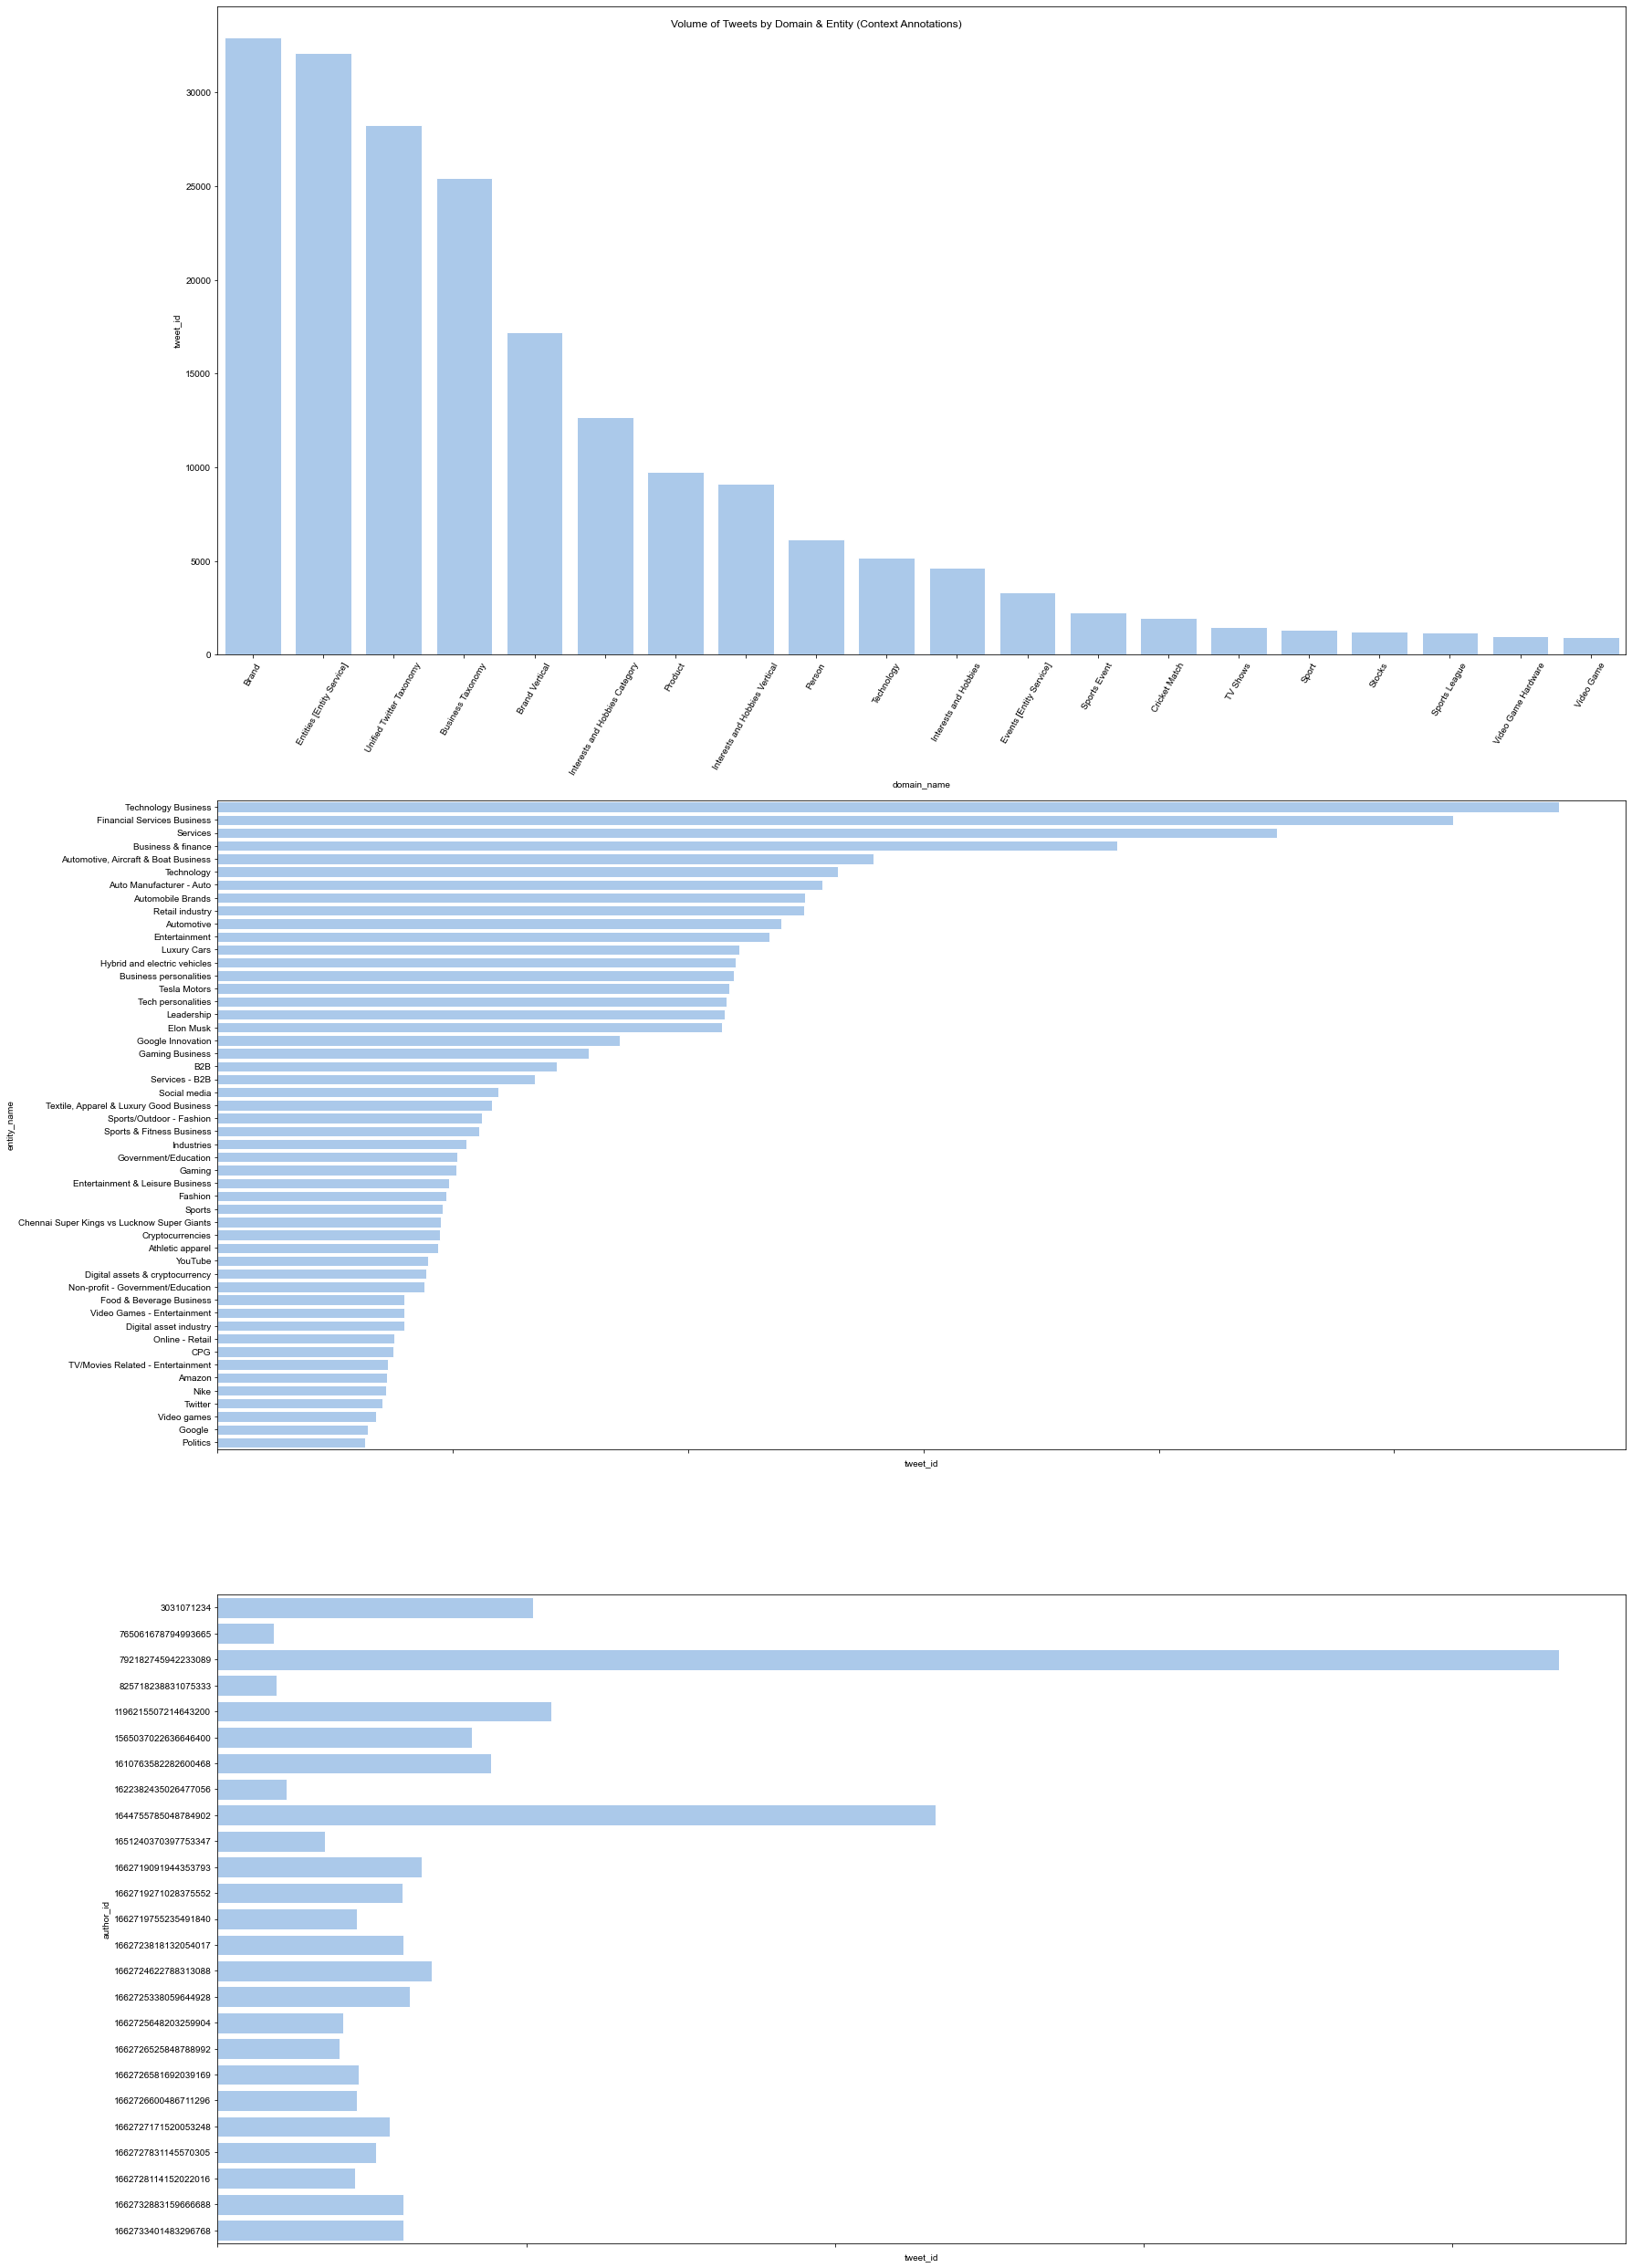

In [13]:
fig, axs = plt.subplots(3, figsize = (25, 35))
fig.suptitle('Volume of Tweets by Domain & Entity (Context Annotations)')

sns.set_theme(style="whitegrid")
sns.set_color_codes("pastel")
sns.barplot(ax=axs[0], x=top_20_domain_counts['domain_name'], y=top_20_domain_counts['tweet_id'], color="b")
sns.barplot(ax=axs[1], x=top_50_entity_counts['tweet_id'], y=top_50_entity_counts['entity_name'], color="b", orient='h')
sns.barplot(ax=axs[2], x=top_25_user_counts['tweet_id'], y=top_25_user_counts['author_id'], color="b", orient='h')


# Rotate the x-axis labels
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=60)
axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=60)
axs[2].set_xticklabels(axs[2].get_xticklabels(), rotation=60)


plt.tight_layout()  # Adjust spacing to avoid label overlap

plt.show()

In [14]:
##DO SOME ANALYSIS USING NTLK ON EACH USER'S BIO 

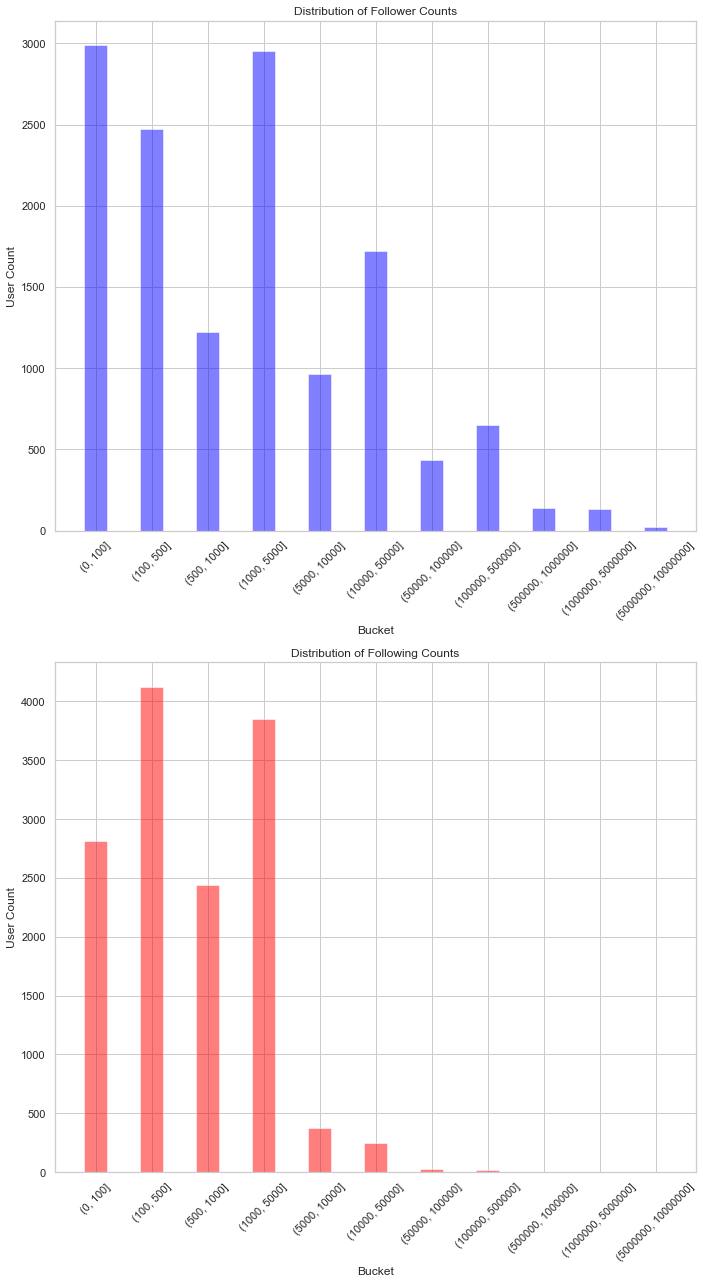

In [15]:
# Define the buckets for follower and following counts
buckets = [0, 100, 500, 1000, 5000, 10000, 50000, 100000, 500000, 1000000, 5000000, 10000000]

# Count the number of users in each bucket
follower_counts = pd.cut(users_df['followers_count'], buckets).value_counts().sort_index()
following_counts = pd.cut(users_df['following_count'], buckets).value_counts().sort_index()
# Create subplots
fig, axs = plt.subplots(2, 1, figsize=(10, 18))

# Plot follower count distribution
axs[0].bar(range(len(follower_counts)), follower_counts, width=0.4, align='center', alpha=0.5, color='blue')
axs[0].set_xlabel('Bucket')
axs[0].set_ylabel('User Count')
axs[0].set_title('Distribution of Follower Counts')
axs[0].set_xticks(range(len(follower_counts)))
axs[0].set_xticklabels(follower_counts.index, rotation=45)

# Plot following count distribution
axs[1].bar(range(len(following_counts)), following_counts, width=0.4, align='center', alpha=0.5, color='red')
axs[1].set_xlabel('Bucket')
axs[1].set_ylabel('User Count')
axs[1].set_title('Distribution of Following Counts')
axs[1].set_xticks(range(len(following_counts)))
axs[1].set_xticklabels(following_counts.index, rotation=45)

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

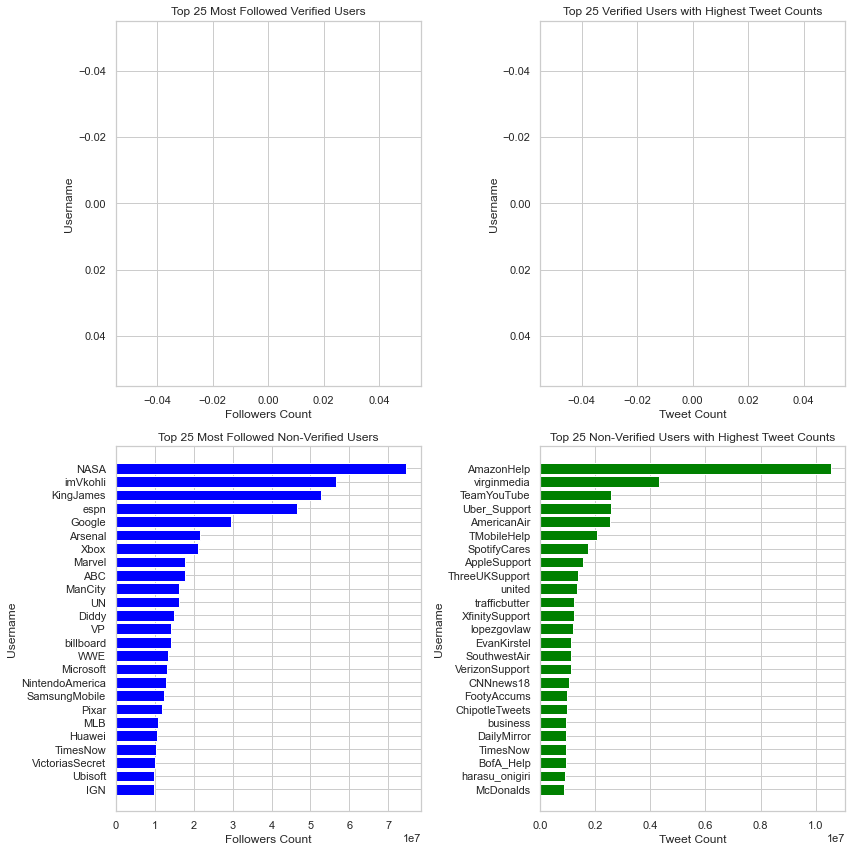

In [16]:
# Convert 'verified' column to integer type
users_df['verified'] = users_df['verified'].astype(int)

# Filter verified users
verified_users = users_df[users_df['verified'] == 1]
non_verified_users = users_df[users_df['verified'] == 0]

# Sort the verified users based on followers count in descending order
top_verified_followed_users = verified_users.sort_values('followers_count', ascending=False).head(25)

# Sort the verified users based on tweet count in descending order
top_verified_tweet_users = verified_users.sort_values('tweet_count', ascending=False).head(25)

# Sort the non-verified users based on followers count in descending order
top_non_verified_followed_users = non_verified_users.sort_values('followers_count', ascending=False).head(25)

# Sort the non-verified users based on tweet count in descending order
top_non_verified_tweet_users = non_verified_users.sort_values('tweet_count', ascending=False).head(25)

# Create a figure with a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# Plot the top followed users (verified)
axs[0, 0].barh(top_verified_followed_users['username'], top_verified_followed_users['followers_count'], color='blue')
axs[0, 0].set_xlabel('Followers Count')
axs[0, 0].set_ylabel('Username')
axs[0, 0].set_title('Top 25 Most Followed Verified Users')
axs[0, 0].invert_yaxis()

# Plot the top tweet users (verified)
axs[0, 1].barh(top_verified_tweet_users['username'], top_verified_tweet_users['tweet_count'], color='green')
axs[0, 1].set_xlabel('Tweet Count')
axs[0, 1].set_ylabel('Username')
axs[0, 1].set_title('Top 25 Verified Users with Highest Tweet Counts')
axs[0, 1].invert_yaxis()

# Plot the top followed users (non-verified)
axs[1, 0].barh(top_non_verified_followed_users['username'], top_non_verified_followed_users['followers_count'], color='blue')
axs[1, 0].set_xlabel('Followers Count')
axs[1, 0].set_ylabel('Username')
axs[1, 0].set_title('Top 25 Most Followed Non-Verified Users')
axs[1, 0].invert_yaxis()

# Plot the top tweet users (non-verified)
axs[1, 1].barh(top_non_verified_tweet_users['username'], top_non_verified_tweet_users['tweet_count'], color='green')
axs[1, 1].set_xlabel('Tweet Count')
axs[1, 1].set_ylabel('Username')
axs[1, 1].set_title('Top 25 Non-Verified Users with Highest Tweet Counts')
axs[1, 1].invert_yaxis()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


## Data Pre-Processing

The following code will remove emoticons, hyperlinks, whitepsaces such as new lines and indentations.
It will also tokenize text into words, remove slang words, and visualize the text pre-processed data to show patterns

In [6]:
def removeUnicode(text):
    """ Removes unicode strings like "\u002c" and "x96" """
    text = re.sub(r'(\\u[0-9A-Fa-f]+)',r'', text)       
    text = re.sub(r'[^\x00-\x7f]',r'',text)
    return text

def replaceURL(text):
    """ Replaces url address with "url" """
    text = re.sub('((www\.[^\s]+)|(https?://[^\s]+))','url',text)
    text = re.sub(r'#([^\s]+)', r'\1', text)
    return text

In [7]:
def removeEmoticons(text):
    """ Removes emoticons from text """
    text = re.sub(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', '', text)
    return text

def countEmoticons(text):
    """ Input: a text, Output: how many emoticons """
    return len(re.findall(':\)|;\)|:-\)|\(-:|:-D|=D|:P|xD|X-p|\^\^|:-*|\^\.\^|\^\-\^|\^\_\^|\,-\)|\)-:|:\'\(|:\(|:-\(|:\S|T\.T|\.\_\.|:<|:-\S|:-<|\*\-\*|:O|=O|=\-O|O\.o|XO|O\_O|:-\@|=/|:/|X\-\(|>\.<|>=\(|D:', text))


In [8]:
nltk.download('stopwords')

""" Tokenizes a text to its words, removes and replaces some of them """    
finalTokens = [] # all tokens
stoplist = stopwords.words('english')
my_stopwords = "multiexclamation multiquestion multistop url atuser st rd nd th am pm" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
allowedWordTypes = ["J","R","V","N"] #  J is Adject, R is Adverb, V is Verb, N is Noun. These are used for POS Tagging

# Create a DataFrame to store the preprocessed text and tweet ID
preprocessed_data = pd.DataFrame(columns=['tweet_id', 'text'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def tokenize(text, wordCountBefore, tweet_id):
    totalAdjectives = 0
    totalAdverbs = 0
    totalVerbs = 0
    onlyOneSentenceTokens = []  # tokens of one sentence each time

    tokens = nltk.word_tokenize(text)

    translator = str.maketrans('', '', string.punctuation)
    text = text.translate(translator)  # Technique 7: remove punctuation

    tokens = nltk.word_tokenize(text)

    tagged = nltk.pos_tag(tokens)  # Technique 13: part of speech tagging
    for w in tagged:
        if w[1][0] in allowedWordTypes and w[0] not in stoplist:
            onlyOneSentenceTokens.append(w[0])
            finalTokens.append(w[0])

    onlyOneSentence = " ".join(onlyOneSentenceTokens)

    # Store the preprocessed text and tweet ID in the DataFrame
    preprocessed_data.loc[len(preprocessed_data)] = [tweet_id, onlyOneSentence]

    return finalTokens

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kushl\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


              tweet_id  \
0  1658150278699565056   
1  1658150503149187076   
2  1658150654756397056   
3  1658150765599371276   
4  1658151031182700552   

                                                                                                                                                                                text  
0                                             dont anything share countries time meantime use Atlas easily incorporate US company set US bank account activate payments Stripe Learn  
1                 HPE NVIDIA FlywheelSoftwa1 developed Biomedical Research Data Platform AI Scale extends realtime clinical insights edge cloud Learn blog HPEGreenLake HPEAlliances  
2  FortiXDR cloud native crossproduct detection response solution adds fullyautomated incident identification investigation remediation Fortinet SecurityFabric Watch learn FortiXDR  
3                                                           DYK NASAs Perseverance Mars rover recently discover

c:\Users\kushl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kushl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0.0, flags=flags)
c:\Users\kushl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128073 missing from current font.
  font.set_text(s, 0, flags=flags)
c:\Users\kushl\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 128175 missing from current font.
  font.set_text(s, 0, flags=flags)


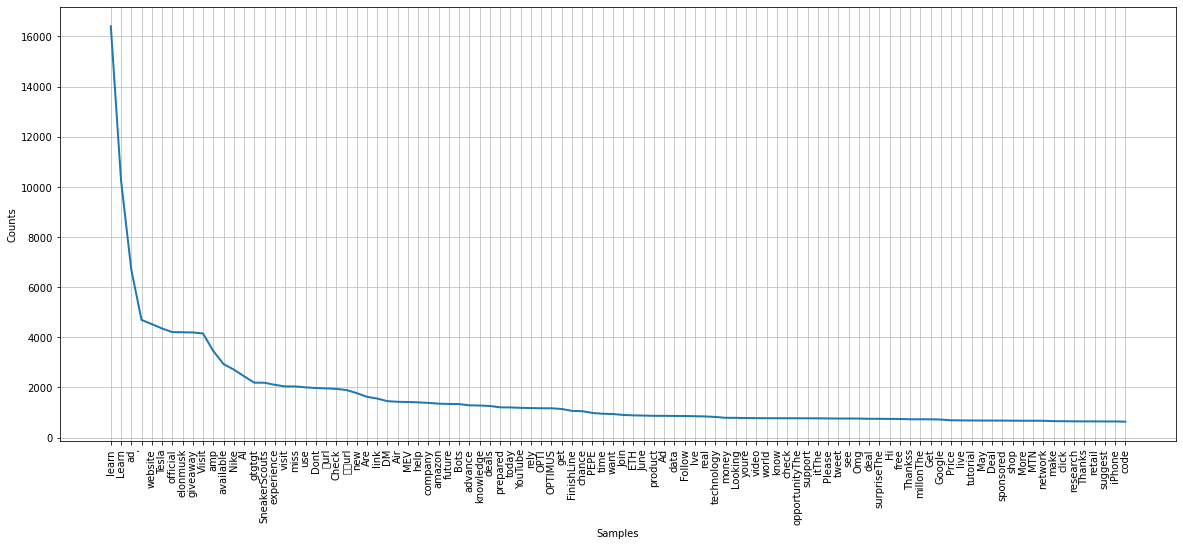

Most common collocations (bigrams)
[('AMDServer', 'intelhpc'), ('AirJordanRetro', 'Raging'), ('ArithmeticUSD', '📍Contract'), ('Blacksail', 'torchlightinfinite'), ('Blader', 'FoxeNews'), ('CaratGlobal', 'Archrival'), ('Ce', 'soir'), ('DD0587600', 'BlackRed'), ('Deutsche', 'Telekom'), ('Elijah', 'Watt'), ('Foxe', 'Blader'), ('Grounded', 'Pentiment'), ('HARVARD', 'ALUMNI'), ('Hyatt', 'Regency'), ('MIKE', 'TROUT'), ('MSIoT', 'IntelIoT'), ('Maruma', 'Mrema'), ('MobileInnovation', 'MSIoT'), ('Mrema', 'cochairperson'), ('NFTArt', 'NFTArtist'), ('NFTArtist', 'NFTCollector'), ('Raging', 'Bulls'), ('Starburst', 'Juicyverse'), ('Thiruvarur', 'வைகாசிமுகூர்த்தம்'), ('WMNS', 'AirJordan1'), ('Watt', 'Sells'), ('calamities', 'befall'), ('cochairperson', 'TNFD'), ('findyourpurpose', 'HirePurpose'), ('meded', 'eMednews'), ('renouncement', 'softcap'), ('revisions', 'OMBs'), ('torchlightXD', 'Gratuit'), ('torchlightinfinite', 'torchlight'), ('வைகாசி', 'முகூர்த்தம்'), ('𝘽𝙚𝙨𝙩', '𝙤𝙛'), ('𝙤𝙛', '𝙩𝙝𝙚'), ('𝙩𝙝𝙚',

In [10]:
from time import time
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

# Retrieve all tweets from the database
query = "SELECT DISTINCT * FROM tweets"
df_tweets = pd.read_sql_query(query, conn)
#Tweet_id is column 0, text is column 3


t0 = time()
totalSentences = 0
totalEmoticons = 0
totalSlangs = 0
totalSlangsFound = []
totalElongated = 0
totalMultiExclamationMarks = 0
totalMultiQuestionMarks = 0
totalMultiStopMarks = 0
totalAllCaps = 0

# Iterate over each row in df_tweets
for index, row in df_tweets.iterrows():
    totalSentences += 1
    feat = []

    tweet_id = row['tweet_id']
    text     = removeUnicode(row['text'])  # Technique 0
    text     = replaceURL(row['text'])

    wordCountBefore = len(re.findall(r'\w+', text))  # word count of one sentence before preprocess

    emoticons = countEmoticons(text)  # how many emoticons in this sentence
    totalEmoticons += emoticons

    text = removeEmoticons(text)  # removes emoticons from text
    tokens = tokenize(text, wordCountBefore, tweet_id)  

    # print("Processed tweet:", tweet_id)  # Print the tweet ID after processing

# View the resulting preprocessed data
print(preprocessed_data.head())
    
print("Total sentences: ",                          totalSentences,"\n")
print("Total Words before preprocess: ",            len(re.findall(r'\w+', ' '.join(df_tweets['text']))))
print("Total Distinct Tokens before preprocess: ",  len(set(re.findall(r'\w+', ' '.join(df_tweets['text'])))))
print("Average word/sentence before preprocess: ",  len(re.findall(r'\w+', ' '.join(df_tweets['text']))) / totalSentences, "\n")
print("Total Words after preprocess: ",             len(tokens))
print("Total Distinct Tokens after preprocess: ",   len(set(tokens)))
print("Average word/sentence after preprocess: ",   len(tokens)/totalSentences,"\n")


print("Total run time: ",                           time() - t0," seconds\n")

print("Total emoticons: ",                          totalEmoticons,"\n")
print("Total slangs: ",                             totalSlangs,"\n")
# commonSlangs = nltk.FreqDist(totalSlangsFound)
# for (word, count) in commonSlangs.most_common(20): # most common slangs across all texts
#     print(word,"\t",count)
# commonSlangs.plot(20, cumulative=False) # plot most common slangs

print("Total elongated words: ",                    totalElongated,"\n")
print("Total multi exclamation marks: ",            totalMultiExclamationMarks)
print("Total multi question marks: ",               totalMultiQuestionMarks)
print("Total multi stop marks: ",                   totalMultiStopMarks,"\n")
print("Total all capitalized words: ",              totalAllCaps,"\n")

#print(tokens)
commonWords = nltk.FreqDist(tokens)
print("Most common words ")
print("Word\tCount")
for (word, count) in commonWords.most_common(100): # most common words across all texts
    print(word,"\t",count)

# Create a larger plot with adjusted dimensions
plt.figure(figsize=(20, 8))  # Adjust the width and height as needed
commonWords.plot(100, cumulative=False) # plot most common words


bgm = nltk.collocations.BigramAssocMeasures()
tgm = nltk.collocations.TrigramAssocMeasures()
bgm_finder = nltk.collocations.BigramCollocationFinder.from_words(tokens)
tgm_finder = nltk.collocations.TrigramCollocationFinder.from_words(tokens)
bgm_finder.apply_freq_filter(5) # bigrams that occur at least 5 times
print("Most common collocations (bigrams)")
print(bgm_finder.nbest(bgm.pmi, 50)) # top 50 bigram collocations
tgm_finder.apply_freq_filter(5) # trigrams that occur at least 5 times
print("Most common collocations (trigrams)")
print(tgm_finder.nbest(tgm.pmi, 20)) # top 20 trigrams collocations

In [13]:
# Merge the preprocessed_data DataFrame with df_tweets based on tweet_id
df_tweets_preprocessed = df_tweets.merge(preprocessed_data, on='tweet_id', how='left', suffixes=('_original', '_preprocessed'))

# Deduplicate the merged DataFrame based on the 'tweet_id' column
df_tweets_preprocessed = df_tweets_preprocessed.drop_duplicates(subset=['tweet_id', 'text_preprocessed'])

In [ ]:
df_tweets_preprocessed.info()
df_tweets_preprocessed.head()

### 6 Parts in BERT TOPIC MODELLING: 
1. Embedding Model 
 2. Dimensionality Reduction 
 3. Clustering
 4. Vectorizer
 5. TF-IDF
 6. Fine Tune Topics

#### EMBEDDING MODEL
BERTopic starts with transforming our input documents into numerical representations. Although there are many ways this can be achieved, we typically use sentence-transformers ("all-MiniLM-L6-v2") as it is quite capable of capturing the semantic similarity between documents.

However, there is not one perfect embedding model and you might want to be using something entirely different for your use case. 
This modularity allows us not only to choose any embedding model to convert our documents into numerical representations, we can use essentially any data to perform our clustering. When new state-of-the-art pre-trained embedding models are released, BERTopic will be able to use them. As a result, BERTopic grows with any new models being released.

#### UMAP & its Hyperparameters
UMAP is a technique used for dimensionality reduction. In BERTopic, it is used to reduce the dimensionality of document embedding into something easier to use with HDBSCAN to create good clusters.
Why this particular clustering model over others? this is because it automatically identifies the number of clusters as opposed to k-means for example which requires a trial and error test to figure out the right number. HDBSCAN does it based on a density based method. 
1. **n_neighbors**: number of neighboring sample points used when making the manifold approximation. Increasing this value often results in larger clusters being created.
2. **n_components**:  refers to the dimensionality of the embeddings after reducing them. This is set as a default to 5 to reduce dimensionality as much as possible whilst trying to maximize the information kept in the resulting embeddings. Although lowering or increasing this value influences the quality of embeddings, its effect is largest on the performance of HDBSCAN. Increasing this value too much and HDBSCAN will have a hard time clustering the high-dimensional embeddings. If you want to increase this value, I would advise setting using a metric for HDBSCAN that works well in high dimensional data.
3. **metric**: refers to the method used to compute the distances in high dimensional space. The default is cosine as we are dealing with high dimensional data.


#### HDBSCAN & Its Hyperparameters
After reducing the embeddings with UMAP, we use HDBSCAN to cluster our documents into clusters of similar documents. Similar to UMAP, HDBSCAN has many parameters that could be tweaked to improve the cluster's quality.
1. **min_cluster_size**: arguably the most important parameter in HDBSCAN.  It controls the minimum size of a cluster and thereby the number of clusters that will be generated. It is set to 10 as a default. Increasing this value results in fewer clusters but of larger size whereas decreasing this value results in more micro clusters being generated. Typically, I would advise increasing this value rather than decreasing it.
2. **min_samples**: is automatically set to min_cluster_size and controls the number of outliers generated. Setting this value significantly lower than min_cluster_size might help you reduce the amount of noise you will get. Do note that outliers are to be expected and forcing the output to have no outliers may not properly represent the data.
3. **metric**:  like with HDBSCAN is used to calculate the distances. Here, we went with euclidean as, after reducing the dimensionality, we have low dimensional data and not much optimization is necessary. However, if you increase n_components in UMAP, then it would be advised to look into metrics that work with high dimensional data.

#### Vectorizers 
In topic modeling, the quality of the topic representations is key for interpreting the topics, communicating results, and understanding patterns. It is of utmost importance to make sure that the topic representations fit with your use case.
In practice, there is not one correct way of creating topic representations. Some use cases might opt for higher n-grams, whereas others might focus more on single words without any stop words. 
1. **ngram_range**: allows us to decide how many tokens each entity is in a topic representation. For example, we have words like game and team with a length of 1 in a topic but it would also make sense to have words like hockey league with a length of 2
2. **stop_words**: In some of the topics, we can see stop words appearing like he or the.
Stop words are something we typically want to prevent in our topic representations as they do not give additional information to the topic
3. **min_df**:  typically an integer representing how frequent a word must be before being added to our representation. You can imagine that if we have a million documents and a certain word only appears a single time across all of them, then it would be highly unlikely to be representative of a topic. Typically, the c-TF-IDF calculation removes that word from the topic representation but when you have millions of documents, that will also lead to a very large topic-term matrix.
4. **max_features**: A parameter similar to min_df is max_features which allows you to select the top n most frequent words to be used in the topic representation. Setting this, for example, to 10_000 creates a topic-term matrix with 10_000 terms. This helps you control the size of the topic-term matrix directly without having to fiddle around with the min_df parameter:
5. **tokenizer**: The default tokenizer in the CountVectorizer works well for western languages but fails to tokenize some non-western languages, like Chinese. 

In [38]:
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np

# Define a function to evaluate BERTopic with given hyperparameters
def evaluate_bertopic(umap_params, hdbscan_params, fix_umap=True):

    df_tweets_preprocessed_filter = df_tweets_preprocessed.sample(n=20000, random_state=42) 

    stopwords_list      = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com', 'gtgtgt', 'please', 'send', 'dm']
    
    # Create BERTopic model with specified hyperparameters
    vectorizer_model = CountVectorizer(min_df=5, ngram_range=(1, 2), stop_words=stopwords_list)
    embedding_model = TransformerDocumentEmbeddings('roberta-base')
    ctfidf = ClassTfidfTransformer(reduce_frequent_words=True)
    
    if fix_umap:
        umap_model = UMAP(n_components=3)  # Fix UMAP components
        hdbscan_model = HDBSCAN(**hdbscan_params)
    else:
        umap_model = UMAP(**umap_params)
        hdbscan_model = HDBSCAN(min_cluster_size = 60, 
                                min_samples = 20, 
                                prediction_data=True,
                                gen_min_span_tree= True)  # Fix HDBSCAN components
    
    model = BERTopic(
        umap_model=umap_model,
        hdbscan_model=hdbscan_model,
        embedding_model=embedding_model,
        vectorizer_model=vectorizer_model,
        ctfidf_model=ctfidf,
        top_n_words=10,
        min_topic_size=100,
        language='english',
        calculate_probabilities=True,
        verbose=True
    )
    
    # Fit the BERTopic model to your data
    topics, probs = model.fit_transform(df_tweets_preprocessed_filter['text_preprocessed'])
    
    # Calculate silhouette score
    silhouette_avg = silhouette_score(probs, hdbscan_model.labels_)
    
    return silhouette_avg

# Define the hyperparameter search space for HDBSCAN
umap_param_space = [
    {'n_neighbors': 5, 'n_components': 3, 'min_dist': 0.0, 'random_state': 42},
    {'n_neighbors': 10, 'n_components': 3, 'min_dist': 0.0, 'random_state': 42},
    {'n_neighbors': 15, 'n_components': 3, 'min_dist': 0.0, 'random_state': 42},
    {'n_neighbors': 20, 'n_components': 3, 'min_dist': 0.0, 'random_state': 42},
    {'n_neighbors': 5, 'n_components': 7, 'min_dist': 0.1, 'random_state': 42},
    {'n_neighbors': 10, 'n_components': 7, 'min_dist': 0.1, 'random_state': 42},
    {'n_neighbors': 15, 'n_components': 7, 'min_dist': 0.1, 'random_state': 42},
    {'n_neighbors': 20, 'n_components': 7, 'min_dist': 0.1, 'random_state': 42},
    {'n_neighbors': 5, 'n_components': 10, 'min_dist': 0.2, 'random_state': 42},
    {'n_neighbors': 10, 'n_components': 10, 'min_dist': 0.2, 'random_state': 42},
    {'n_neighbors': 15, 'n_components': 10, 'min_dist': 0.2, 'random_state': 42},
    {'n_neighbors': 20, 'n_components': 10, 'min_dist': 0.2, 'random_state': 42}
]

hdbscan_param_space = [
    {'min_cluster_size': 10, 'min_samples': 5, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 20, 'min_samples': 10, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 40, 'min_samples': 15, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 80, 'min_samples': 30, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 10, 'min_samples': 5, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 20, 'min_samples': 10, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 40, 'min_samples': 15, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 60, 'min_samples': 20, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 10, 'min_samples': 5, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 20, 'min_samples': 10, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 40, 'min_samples': 15, 'gen_min_span_tree': True, 'prediction_data': True},
    {'min_cluster_size': 80, 'min_samples': 30, 'gen_min_span_tree': True, 'prediction_data': True}

]


# Initialize the best hyperparameters and silhouette score
best_hdbscan_params = None
best_umap_params = None
best_silhouette_score = -1.0  # Initialize with a low value

# First, fix HDBSCAN components and tune UMAP components
print("Fixing HDBSCAN components and tuning UMAP...")
for i, umap_params in enumerate(umap_param_space):
    sil_score = evaluate_bertopic(umap_params, hdbscan_param_space, fix_umap=False)
    if sil_score > best_silhouette_score:
        best_silhouette_score = sil_score
        best_umap_params = umap_params
    print(f"Progress: {i + 1}/{len(umap_param_space)} completed")


# Print the best HDBSCAN components and corresponding silhouette score
print("Best UMAP Params (Fixed HDBSCAN):", best_umap_params)
print("Best Silhouette Score (Fixed HDBSCAN):", best_silhouette_score)

# Reset the best silhouette score
best_silhouette_score = -1.0

# Next, fix UMAP components and tune HDBSCAN components
print("Fixing UMAP components and tuning HDBSCAN...")
for i, hdbscan_params in enumerate(hdbscan_param_space):
    sil_score = evaluate_bertopic(best_umap_params, hdbscan_params, fix_umap=True)
    if sil_score > best_silhouette_score:
        best_silhouette_score = sil_score
        best_hdbscan_params = hdbscan_params
    print(f"Progress: {i + 1}/{len(hdbscan_param_space)} completed")

# Print the best HDBSCAN components and corresponding silhouette score
print("Best HDBSCAN Params (Fixed UMAP):", best_hdbscan_params)
print("Best Silhouette Score (Fixed UMAP):", best_silhouette_score)

Fixing HDBSCAN components and tuning UMAP...


100%|██████████| 20000/20000 [36:37<00:00,  9.10it/s] 
2023-09-24 21:24:02,277 - BERTopic - Transformed documents to Embeddings
2023-09-24 21:24:15,019 - BERTopic - Reduced dimensionality
2023-09-24 21:24:24,710 - BERTopic - Clustered reduced embeddings


Progress: 1/12 completed


100%|██████████| 20000/20000 [35:21<00:00,  9.43it/s] 
2023-09-24 21:59:56,983 - BERTopic - Transformed documents to Embeddings
2023-09-24 22:00:14,259 - BERTopic - Reduced dimensionality
2023-09-24 22:00:22,795 - BERTopic - Clustered reduced embeddings


Progress: 2/12 completed


100%|██████████| 20000/20000 [36:30<00:00,  9.13it/s] 
2023-09-24 22:37:05,191 - BERTopic - Transformed documents to Embeddings
2023-09-24 22:37:27,235 - BERTopic - Reduced dimensionality
2023-09-24 22:37:34,330 - BERTopic - Clustered reduced embeddings


Progress: 3/12 completed


100%|██████████| 20000/20000 [37:26<00:00,  8.90it/s] 
2023-09-24 23:15:11,573 - BERTopic - Transformed documents to Embeddings
2023-09-24 23:15:36,208 - BERTopic - Reduced dimensionality
2023-09-24 23:15:43,303 - BERTopic - Clustered reduced embeddings


Progress: 4/12 completed


100%|██████████| 20000/20000 [37:09<00:00,  8.97it/s] 
2023-09-24 23:53:02,780 - BERTopic - Transformed documents to Embeddings
2023-09-24 23:53:18,532 - BERTopic - Reduced dimensionality
2023-09-24 23:53:26,286 - BERTopic - Clustered reduced embeddings


Progress: 5/12 completed


100%|██████████| 20000/20000 [35:45<00:00,  9.32it/s] 
2023-09-25 00:29:22,175 - BERTopic - Transformed documents to Embeddings
2023-09-25 00:29:44,196 - BERTopic - Reduced dimensionality
2023-09-25 00:29:51,957 - BERTopic - Clustered reduced embeddings


Progress: 6/12 completed


100%|██████████| 20000/20000 [35:16<00:00,  9.45it/s]
2023-09-25 01:05:18,935 - BERTopic - Transformed documents to Embeddings
2023-09-25 01:05:45,161 - BERTopic - Reduced dimensionality
2023-09-25 01:05:50,503 - BERTopic - Clustered reduced embeddings


Progress: 7/12 completed


100%|██████████| 20000/20000 [35:31<00:00,  9.38it/s]
2023-09-25 01:41:31,603 - BERTopic - Transformed documents to Embeddings
2023-09-25 01:42:00,476 - BERTopic - Reduced dimensionality
2023-09-25 01:42:07,223 - BERTopic - Clustered reduced embeddings


Progress: 8/12 completed


100%|██████████| 20000/20000 [35:57<00:00,  9.27it/s] 
2023-09-25 02:18:14,357 - BERTopic - Transformed documents to Embeddings
2023-09-25 02:18:31,428 - BERTopic - Reduced dimensionality
2023-09-25 02:18:37,826 - BERTopic - Clustered reduced embeddings


Progress: 9/12 completed


100%|██████████| 20000/20000 [35:21<00:00,  9.43it/s]
2023-09-25 02:54:09,529 - BERTopic - Transformed documents to Embeddings
2023-09-25 02:54:32,990 - BERTopic - Reduced dimensionality
2023-09-25 02:54:41,170 - BERTopic - Clustered reduced embeddings


Progress: 10/12 completed


100%|██████████| 20000/20000 [35:15<00:00,  9.45it/s]
2023-09-25 03:30:06,524 - BERTopic - Transformed documents to Embeddings
2023-09-25 03:30:34,666 - BERTopic - Reduced dimensionality
2023-09-25 03:30:41,045 - BERTopic - Clustered reduced embeddings


Progress: 11/12 completed


100%|██████████| 20000/20000 [35:52<00:00,  9.29it/s] 
2023-09-25 04:06:43,482 - BERTopic - Transformed documents to Embeddings
2023-09-25 04:07:14,658 - BERTopic - Reduced dimensionality
2023-09-25 04:07:22,294 - BERTopic - Clustered reduced embeddings


Progress: 12/12 completed
Best UMAP Params (Fixed HDBSCAN): {'n_neighbors': 15, 'n_components': 7, 'min_dist': 0.1, 'random_state': 42}
Best Silhouette Score (Fixed HDBSCAN): 0.5015467858854366
Fixing UMAP components and tuning HDBSCAN...


100%|██████████| 20000/20000 [35:26<00:00,  9.40it/s]
2023-09-25 04:42:58,688 - BERTopic - Transformed documents to Embeddings
2023-09-25 04:43:11,424 - BERTopic - Reduced dimensionality
2023-09-25 04:52:14,944 - BERTopic - Clustered reduced embeddings


Progress: 1/12 completed


100%|██████████| 20000/20000 [35:35<00:00,  9.36it/s]
2023-09-25 05:28:04,265 - BERTopic - Transformed documents to Embeddings
2023-09-25 05:28:16,993 - BERTopic - Reduced dimensionality
2023-09-25 05:29:27,611 - BERTopic - Clustered reduced embeddings


Progress: 2/12 completed


100%|██████████| 20000/20000 [35:15<00:00,  9.46it/s]
2023-09-25 06:04:53,867 - BERTopic - Transformed documents to Embeddings
2023-09-25 06:05:07,268 - BERTopic - Reduced dimensionality
2023-09-25 06:05:21,501 - BERTopic - Clustered reduced embeddings


Progress: 3/12 completed


100%|██████████| 20000/20000 [35:47<00:00,  9.31it/s]
2023-09-25 06:41:19,386 - BERTopic - Transformed documents to Embeddings
2023-09-25 06:41:33,841 - BERTopic - Reduced dimensionality
2023-09-25 06:41:38,590 - BERTopic - Clustered reduced embeddings


Progress: 4/12 completed


100%|██████████| 20000/20000 [35:28<00:00,  9.40it/s] 
2023-09-25 07:17:16,308 - BERTopic - Transformed documents to Embeddings
2023-09-25 07:17:28,976 - BERTopic - Reduced dimensionality
2023-09-25 07:26:25,396 - BERTopic - Clustered reduced embeddings


Progress: 5/12 completed


100%|██████████| 20000/20000 [35:00<00:00,  9.52it/s]
2023-09-25 08:01:39,057 - BERTopic - Transformed documents to Embeddings
2023-09-25 08:01:52,835 - BERTopic - Reduced dimensionality
2023-09-25 08:03:05,018 - BERTopic - Clustered reduced embeddings


Progress: 6/12 completed


100%|██████████| 20000/20000 [35:20<00:00,  9.43it/s]
2023-09-25 08:38:36,876 - BERTopic - Transformed documents to Embeddings
2023-09-25 08:38:49,271 - BERTopic - Reduced dimensionality
2023-09-25 08:39:01,458 - BERTopic - Clustered reduced embeddings


Progress: 7/12 completed


100%|██████████| 20000/20000 [35:30<00:00,  9.39it/s] 
2023-09-25 09:14:41,684 - BERTopic - Transformed documents to Embeddings
2023-09-25 09:14:55,336 - BERTopic - Reduced dimensionality
2023-09-25 09:15:02,259 - BERTopic - Clustered reduced embeddings


Progress: 8/12 completed


100%|██████████| 20000/20000 [37:40<00:00,  8.85it/s] 
2023-09-25 09:52:52,742 - BERTopic - Transformed documents to Embeddings
2023-09-25 09:53:06,796 - BERTopic - Reduced dimensionality
2023-09-25 10:01:32,655 - BERTopic - Clustered reduced embeddings


Progress: 9/12 completed


100%|██████████| 20000/20000 [37:56<00:00,  8.78it/s]
2023-09-25 10:39:43,918 - BERTopic - Transformed documents to Embeddings
2023-09-25 10:39:57,965 - BERTopic - Reduced dimensionality
2023-09-25 10:41:14,114 - BERTopic - Clustered reduced embeddings


Progress: 10/12 completed


100%|██████████| 20000/20000 [36:41<00:00,  9.09it/s] 
2023-09-25 11:18:08,134 - BERTopic - Transformed documents to Embeddings
2023-09-25 11:18:21,824 - BERTopic - Reduced dimensionality
2023-09-25 11:18:34,592 - BERTopic - Clustered reduced embeddings


Progress: 11/12 completed


100%|██████████| 20000/20000 [37:22<00:00,  8.92it/s] 
2023-09-25 11:56:06,651 - BERTopic - Transformed documents to Embeddings
2023-09-25 11:56:20,091 - BERTopic - Reduced dimensionality
2023-09-25 11:56:24,266 - BERTopic - Clustered reduced embeddings


Progress: 12/12 completed
Best HDBSCAN Params (Fixed UMAP): {'min_cluster_size': 80, 'min_samples': 30, 'gen_min_span_tree': True, 'prediction_data': True}
Best Silhouette Score (Fixed UMAP): 0.4593027554190281


In [43]:
from sklearn.metrics import silhouette_score
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer
from umap import UMAP
from hdbscan import HDBSCAN
import numpy as np


# Build the pipeline with the current parameter settings
stopwords_list      = list(stopwords.words('english')) + ['http', 'https', 'amp', 'com', 'gtgtgt', 'please', 'send', 'dm']
vectorizer_model    = CountVectorizer(min_df=5, 
                                      ngram_range=(1, 2), 
                                      stop_words=stopwords_list)
embedding_model     = TransformerDocumentEmbeddings('roberta-base')
umap_model          = UMAP(n_neighbors= 25, 
                           n_components= 5, 
                           min_dist= 0.0, 
                           random_state= 42)
hdbscan_model       = HDBSCAN(min_cluster_size= 100, 
                              min_samples= 40, 
                              gen_min_span_tree=True, 
                              prediction_data=True)
ctfidf = ClassTfidfTransformer(reduce_frequent_words=True)

model = BERTopic(
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf,
    top_n_words=10,
    min_topic_size=100,
    language='english',
    calculate_probabilities=True,
    verbose=True
    # nr_topics = 30,
    )

# Fit the BERTopic model
topics, probs = model.fit_transform(df_tweets_preprocessed['text_preprocessed'])

# Calculate silhouette score
silhouette_avg = silhouette_score(probs, hdbscan_model.labels_)
        
# Assign cluster labels to each tweet
df_tweets_preprocessed['cluster_label'] = topics
        
# Attach a score to each row based on the probability of the assigned topic
df_tweets_preprocessed['topic_probability'] = probs.max(axis=1)

print(silhouette_avg)

100%|██████████| 36370/36370 [1:05:55<00:00,  9.19it/s]
2023-09-26 22:13:39,225 - BERTopic - Transformed documents to Embeddings
2023-09-26 22:14:38,445 - BERTopic - Reduced dimensionality
2023-09-26 22:14:51,817 - BERTopic - Clustered reduced embeddings


0.3926850183788717


In [40]:
freq = model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,-1,12663,-1_blockchain_ice_share_data,"[blockchain, ice, share, data, june, service, future, healthcare, oracle, join]","[heisrema DONJAZZY Get YouTube channel monetized today start making money daily USD home even create new YouTube channel ’ yet also get monetized Use link learn get started 👇🏻👇🏻👇🏻, officialnairam1 Get YouTube channel monetized today start making money daily USD home even create new YouTube channel ’ yet also get monetized Use link learn get started 👇🏻👇🏻👇🏻, veeiye Get YouTube channel monetized today start making money daily USD home even create new YouTube channel ’ yet also get monetized Use link learn get started 👇🏻👇🏻👇🏻]"
1,0,3059,0_solutions_un_research_unep,"[solutions, un, research, unep, hpe, courtesy, program, innovation, energy, join]","[support TheFluLab launching pilot Open Science Community Trainer Certification Program Apply June promote open science adoption influenza research Gain skills recognition open science advocate ℹ️ Learn, leading consulting partner global private equity industry proud Principal Consultant sponsor SuperReturn International Berlin June Learn event meet team members site, partnership journey starts USAID welcome partners sizes develop sustainable solutions global challenges Learn partner Work USAID event American Corner Surkhet May]"
2,1,2041,1_nike_sneakerscouts_sneakerscouts nike_air,"[nike, sneakerscouts, sneakerscouts nike, air, ad nike, nike air, jumpman23, womens, available, air jordan]","[SneakerScouts Nike Womens Air Max Cobalt Bliss available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt, SneakerScouts Nike Womens Air Max Cobalt Bliss available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt, SneakerScouts Nike Womens Air Max Hemp available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt]"
3,2,1954,2_target_shop_im_walmart,"[target, shop, im, walmart, bluray, learned, google, gon, ive, bbc]","[FundUrBiz YouTube Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial, BenLloydHoes Disney DisneyStudios Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial, DB99 Walmart Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial]"
4,3,1374,3_advance company_prepared use_company rely_learn opti,"[advance company, prepared use, company rely, learn opti, optimus, opti optimus, opti, ai advance, experience visit, use ai]","[davidgokhshtein Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS, atgoodm Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS, pepepunknfts Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS]"
5,4,1202,4_database_awscloud_todays_blockchain,"[database, awscloud, todays, blockchain, defi, thread, future, ethereum, aws, news]","[dbInsight Research Let use case drive database choice 💡 Read insightful white paper discover choose right database AWSCloud Contact TMM Enterprises Group Inc learn, Discover build secure compliant cloud architecture AWSCloud data security best practices 🔐☁️ Read article learn questions Precoh help, Discover build secure compliant cloud architecture AWSCloud data security best practices 🔐☁️ Read article learn questions Handley Global Group LLC help]"
6,5,985,5_stream_twitch_xfinity_game,"[stream, twitch, xfinity, game, live, sponsored, stream sponsored, play, diablo, live twitch]","[🔴LIVE ON TWITCH Todays stream Sponsored RaidRPG support stream come try game game Available BOTH PC Mobile, Going live twitch Today ’ stream sponsored RaidRPG Support stream downloading FreeToPlay game PC Mobile using link RaidShadowLegends, Today ’ stream sponsored raidrpg Please support stream downloading game PC Mobile play along Download link sponsored ad twitch twitchstreamer raidshadowlegends plarium whosagames raidshadowlegendsmemes]"
7,6,841,6_wed_lik

**Update Topics**

After generating our updated topics, we can feed them back into BERTopic in one of two ways. We can either update the topic representations themselves based on the documents that now belong to new topics or we can only update the topic frequency without updating the topic representations themselves.

In [41]:
# Use the "c-TF-IDF" strategy with a threshold
new_topics = model.reduce_outliers(df_tweets_preprocessed['text_preprocessed'], topics, strategy="c-tf-idf")    
model.update_topics(df_tweets_preprocessed['text_preprocessed'], topics=new_topics)

## Rep Docs

- Represent the top tweets which are used to come up with the names
- You can use this when you manually validate the results as the name should indicate what all the tweets should represent
    - For example, the name indicates that 'ad' is one of the common words, however we do NOT want this within the name so we can remove that word in all tweets. remove any over-represented words in the cluster
- You can use TF-IDF to remove words that may be present in 80% of the documents for example. high frequency terms should be removed using that technique

In [42]:
freq = model.get_topic_info()
freq

,Topic,Count,Name,Representation,Representative_Docs
0,0,4392,0_learn_amp_join_june,"[learn, amp, join, june, program, may, research, new, solutions, support]","[support TheFluLab launching pilot Open Science Community Trainer Certification Program Apply June promote open science adoption influenza research Gain skills recognition open science advocate ℹ️ Learn, leading consulting partner global private equity industry proud Principal Consultant sponsor SuperReturn International Berlin June Learn event meet team members site, partnership journey starts USAID welcome partners sizes develop sustainable solutions global challenges Learn partner Work USAID event American Corner Surkhet May]"
1,1,2491,1_nike_sneakerscouts_gtgtgt_available,"[nike, sneakerscouts, gtgtgt, available, air, finishline, ad, retail, jumpman23, womens]","[SneakerScouts Nike Womens Air Max Cobalt Bliss available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt, SneakerScouts Nike Womens Air Max Cobalt Bliss available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt, SneakerScouts Nike Womens Air Max Hemp available FinishLine use code SPRINGKICKINS retail ad Nike gtgtgt]"
2,2,2355,2_shop_learn_google_target,"[shop, learn, google, target, im, walmart, youtube, ad, ive, where]","[FundUrBiz YouTube Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial, BenLloydHoes Disney DisneyStudios Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial, DB99 Walmart Ive made decent amount ETH week MEV Bots youre curious learn click link watch quick tutorial]"
3,3,1752,3_opti_optimus_rely_prepared,"[opti, optimus, rely, prepared, knowledge, advance, company, are, ai, use]","[davidgokhshtein Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS, atgoodm Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS, pepepunknfts Are prepared use AI advance company rely knowledge experience visit learn OPTI OPTIMUS]"
4,4,2364,4_learn_future_aws_data,"[learn, future, aws, data, blockchain, ai, awscloud, cloud, platform, news]","[dbInsight Research Let use case drive database choice 💡 Read insightful white paper discover choose right database AWSCloud Contact TMM Enterprises Group Inc learn, Discover build secure compliant cloud architecture AWSCloud data security best practices 🔐☁️ Read article learn questions Precoh help, Discover build secure compliant cloud architecture AWSCloud data security best practices 🔐☁️ Read article learn questions Handley Global Group LLC help]"
5,5,1813,5_sponsored_stream_twitch_live,"[sponsored, stream, twitch, live, game, ad, xfinity, come, play, new]","[🔴LIVE ON TWITCH Todays stream Sponsored RaidRPG support stream come try game game Available BOTH PC Mobile, Going live twitch Today ’ stream sponsored RaidRPG Support stream downloading FreeToPlay game PC Mobile using link RaidShadowLegends, Today ’ stream sponsored raidrpg Please support stream downloading game PC Mobile play along Download link sponsored ad twitch twitchstreamer raidshadowlegends plarium whosagames raidshadowlegendsmemes]"
6,6,1173,6_please_send_dm_hi,"[please, send, dm, hi, like, wed, details, sorry, thank, hear]","[KasaunTianna Hi saw comment wanted reach learn happened love opportunity help way moment please send Direct Message details full name phone number email address Thanks NR, TyANet Hi Im sorry hear experience like learn Please reach private message message include name email phone number store location additional information took place look Thank, SwordNjustice Hey thanks reaching like learn experience see help start feel free send DM details going full name phone number email Jack]"
7,7,801,7_miss_dont_opportunitythe_viisit,"[miss, dont, opportunitythe, viisit, official, giveaway, tesla, url, website, itthe]","[dandillondev elonmusk chance Dont miss itThe official Tesla giveaway Viisit website learn 👉url, RoyBntz elonmusk

In [38]:
model.visualize_topics()

In [29]:
model.visualize_barchart()

Manual Topic Reduction¶
Each resulting topic has its feature vector constructed from c-TF-IDF. Using those feature vectors, we can find the most similar topics and merge them. If we do this iteratively, starting from the least frequent topic, we can reduce the number of topics quite easily. We do this until we reach the value of nr_topics:

In [ ]:
topics_to_merge = [[1, 2]
                   [3, 4]]
topic_model.merge_topics(docs, topics_to_merge)

Automatic Topic Reduction¶
One issue with the approach above is that it will merge topics regardless of whether they are very similar. They are simply the most similar out of all options. This can be resolved by reducing the number of topics automatically. To do this, we can use HDBSCAN to cluster our topics using each c-TF-IDF representation. Then, we merge topics that are clustered together. Another benefit of HDBSCAN is that it generates outliers. These outliers prevent topics from being merged if no other topics are similar.

In [ ]:
from bertopic import BERTopic
topic_model = BERTopic(nr_topics="auto")

In [ ]:
from bertopic.representation import TextGeneration

prompt = "I have a topic described by the following keywords: [KEYWORDS]. Based on the previous keywords, what is this topic about?""

# Create your representation model
generator = pipeline('text2text-generation', model='google/flan-t5-base')
representation_model = TextGeneration(generator)

In [45]:
model.visualize_distribution(probs[200], min_probability=0.015)

In [47]:
model.visualize_hierarchy(top_n_topics=20)

In [48]:
model.visualize_term_rank()

In [ ]:
import pandas as pd
import numpy as np

# Sample data (replace with your Twitter user data)
data = {
    'Username': ['User1', 'User2', 'User3'],
    'Followers': [1000, 5000, 2000],
    'Tweets': [200, 300, 150],
    'Days_Since_Last_Tweet': [3, 1, 5],
    'Avg_Likes_Per_Tweet': [20, 15, 10],
    'Avg_Comments_Per_Tweet': [5, 4, 3],
    'Avg_Impressions_Per_Tweet': [5000, 6000, 4000],
    'Location': ['New York', 'Los Angeles', 'Chicago'],
    'Tweets_in_Domain': [50, 30, 60]
}

# Create a DataFrame from the sample data
df = pd.DataFrame(data)

# Define weights for each criterion
weights = {
    'Followers': 0.2,
    'Tweets': 0.1,
    'Days_Since_Last_Tweet': 0.1,
    'Avg_Likes_Per_Tweet': 0.15,
    'Avg_Comments_Per_Tweet': 0.15,
    'Avg_Impressions_Per_Tweet': 0.15,
    'Location': 0.05,
    'Tweets_in_Domain': 0.1
}

# Normalize data (convert to values between 0 and 1)
# You can use the min/max function to normalize the data -> normalization and standardization functions
# Replicates what we do below but simpler way BTS.
# in Sci-kit Learn you can use the normalize function in preprocessing module.
for criterion in weights.keys():
    df[criterion] = (df[criterion] - df[criterion].min()) / (df[criterion].max() - df[criterion].min())

# Calculate scores for each user
def calculate_score(row):
    score = sum(row[criterion] * weight for criterion, weight in weights.items())
    return score

df['Score'] = df.apply(calculate_score, axis=1)

# Rank users based on their scores
df = df.sort_values(by='Score', ascending=False)

# Display the ranked users
print(df[['Username', 'Score']])